# Imports

In [ ]:
# import's
from zipfile import ZipFile
import h5py
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random

from torchvision import models

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
import torch
from datetime import datetime
from PIL import Image

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Duomenų parsisiuntimas iš Kaggle

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset

# Duomenų apdorojimas failineje sistemoje

In [ ]:
# unzip dataset
file = 'figshare-brain-tumor-dataset.zip'

with ZipFile(file, 'r') as zip:
    zip.extractall()

In [ ]:
# get all mat files paths
filepaths = glob('/content/dataset/data/*.mat')

# Dataset ir dataloader kūrimas

In [ ]:
# dataset class for get and prepared data for model learning
class BrainTumorDataset_RGB(Dataset):
  def __init__(self, mat_files_path, is_train=False):
    self.mat_files_path = mat_files_path
    self.is_train = is_train

  def __len__(self):
    return len(self.mat_files_path)

  def resize(self, image, mask):
    resize_transform = transforms.Resize((256, 256))
    image = resize_transform(image)
    mask = mask.unsqueeze(0)
    mask = resize_transform(mask)
    return image, mask

  def normalize(self, image):
    image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
    return image

  def flip(self, image, mask):
    if random.random() > 0.5:
      image = transforms.functional.hflip(image)
      mask = transforms.functional.hflip(mask)

    if random.random() > 0.5:
      image = transforms.functional.vflip(image)
      mask = transforms.functional.vflip(mask)

    return image, mask

  def __getitem__(self, idx):
    file_path = self.mat_files_path[idx]
    with h5py.File(file_path, 'r') as file:
      image = file.get('cjdata/image/')[()]
      mask = file.get('cjdata/tumorMask/')[()]
      label = file.get('cjdata/label/')[()]

    image = torch.from_numpy(image).float().unsqueeze(0).repeat(3, 1, 1)
    mask = torch.from_numpy(mask).float()
    label = label[0][0]

    if(self.is_train):
      image, mask = self.flip(image, mask)

    image, mask = self.resize(image, mask)
    image = self.normalize(image)

    return image, label-1, mask

In [ ]:
# splitting data paths in train, valid, test datasets
dataset_paths_train, dataset_paths_test_valid = train_test_split(filepaths, test_size=0.3, random_state=42)
dataset_paths_valid, dataset_paths_test = train_test_split(dataset_paths_test_valid, test_size=0.5, random_state=42)

In [ ]:
# creating actual datasets
dataset_train = BrainTumorDataset_RGB(dataset_paths_train, is_train = True)
dataset_valid = BrainTumorDataset_RGB(dataset_paths_valid, is_train = False)
dataset_test = BrainTumorDataset_RGB(dataset_paths_test, is_train = False)

In [ ]:
# printing dataset sizes
print('Mokymo duomenų aibeje yra -', len(dataset_train))
print('Validavimo duomenų aibeje yra -', len(dataset_valid))
print('Testavimo duomenų aibeje yra -', len(dataset_test))

Mokymo duomenų aibeje yra - 2144
Validavimo duomenų aibeje yra - 460
Testavimo duomenų aibeje yra - 460


In [ ]:
# creating dataloaders
loader_train = DataLoader(dataset_train, batch_size = 32, shuffle=True, num_workers = 2)
loader_valid = DataLoader(dataset_valid, batch_size = 32, shuffle=False, num_workers = 2)
loader_test = DataLoader(dataset_test, batch_size = 32, shuffle=False, num_workers = 1)

# Gpu device

In [ ]:
# creating gpu device for better performance
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Papildomos funkcijos

In [ ]:
import sys
import os

# Funkcija, kuri nukreips stdout į null (niekur nespausdins)
class SuppressOutput:
    def __enter__(self):
        self.original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self.original_stdout

In [ ]:
# function to convert index to label
index_to_label = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

In [ ]:
# funkcija, kuri paskaičiuoja laiką [valandų]:minučių:sekundžių formatu
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [ ]:
# funkcija, kuri nubraižo du grafikus: loss funkcijos ir tikslumo
def plot_results(epoch_count, train_loss, train_acc, valid_acc):
  plt.figure(figsize=(8,4))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epoch_count+1),train_loss, 'b', label = 'Mokymo nuostolis')
  plt.ylim(0.0, 1.0)
  plt.title('Modelio nuostolių funkcija mokymo metu')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epochos')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epoch_count+1), train_acc, 'b', label = 'Mokymo tikslumas')
  plt.plot(range(1, epoch_count+1), valid_acc, 'r', label = 'Validavimo tikslumas')
  plt.ylim(0.0, 1.0)
  plt.title('Modelio tikslumas mokymo metu')
  plt.ylabel('Tikslumas')
  plt.xlabel('Epochos')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# funkcija, skirta sukurti klasifikavimo matricai ir ją atspausdinti
# funkcijos argumentai: tikros ir modelio spėjamos klasių reikšmės
def create_and_print_matrix(ground_truth, predictions):
  # constant for classes
  classes = ('Meningioma', 'Glioblastoma', 'Hipofizės')

  # build confusion matrix
  matrix = confusion_matrix(ground_truth, predictions)
  data_frame = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])

  plt.figure(figsize = (4,4))
  plt.show()
  plt.tight_layout()
  sn.heatmap(data_frame, annot=True, cbar=None, fmt="d") # cmap="YlGnBu"

# Mokymo ir vertinimo funkcijos

In [ ]:
def evaluate(model, loader):
  model.eval()

  ground_truth = []
  predictions = []

  for data in loader:
    images = data[0].to(device)
    labels = data[1]

    with torch.no_grad():
      output = model(images)

    pred_label = torch.argmax(output, axis = 1)
    predictions = np.append(predictions, pred_label.cpu().detach())
    ground_truth = np.append(ground_truth, labels)

  return predictions, ground_truth

In [ ]:
def evaluate_while_training(model, loader):
  predictions, ground_truth = evaluate(model, loader)
  correct_predictions = np.sum(predictions == ground_truth)
  total_predictions = ground_truth.size
  accuracy = correct_predictions / total_predictions

  return accuracy

In [ ]:
def train_one_epoch(model, loader, loss_func, optimizer):
  loss_acum = []

  model.train()

  for data in loader:
    images = data[0].to(device)
    labels = data[1].long().to(device)

    pred = model(images)
    loss = loss_func(pred, labels)
    loss_acum = np.append(loss_acum, loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return np.mean(loss_acum)

In [ ]:
def train_all_epochs(model, loader_train, loader_valid, loss_fn, optimizer, epoch_count = 10):

  start_time = datetime.now()

  train_accuracy_acum = []
  valid_accuracy_acum = []
  train_loss_acum = []

  for epoch in range(epoch_count):
    loss_avr = train_one_epoch(model, loader_train, loss_fn, optimizer)
    train_loss_acum.append(loss_avr)

    # evaluation
    train_accuracy = evaluate_while_training(model, loader_train)
    train_accuracy_acum.append(train_accuracy)
    valid_accuracy = evaluate_while_training(model, loader_valid)
    valid_accuracy_acum.append(valid_accuracy)

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss_avr}')
    print(f'  Training accuracy: {np.round(train_accuracy * 100, 2)}, Validation accuracy: {np.round(valid_accuracy * 100, 2)}')

  return train_accuracy_acum, valid_accuracy_acum, train_loss_acum

# Modelio apmokymas - 1

In [ ]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[-1] = torch.nn.Linear(4096, 3)
vgg_model = vgg_model.to(device)

In [ ]:
loss_fn_class = torch.nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam(vgg_model.classifier.parameters(), lr = 0.0005)

In [ ]:
epoch_count = 45

In [ ]:
train_iou_class, valid_iou_class, train_loss_class = train_all_epochs(vgg_model, loader_train, loader_valid, loss_fn_class, optimizer_class, epoch_count = epoch_count)
plot_results(epoch_count, train_loss_class, train_iou_class, valid_iou_class)

# Modelio apmokymas - 2

In [ ]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[-1] = torch.nn.Linear(4096, 3)
vgg_model = vgg_model.to(device)

In [ ]:
loss_fn_class = torch.nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam(vgg_model.parameters(), lr = 0.0005)

In [ ]:
epoch_count = 45

In [ ]:
train_iou_class, valid_iou_class, train_loss_class = train_all_epochs(vgg_model, loader_train, loader_valid, loss_fn_class, optimizer_class, epoch_count = epoch_count)
plot_results(epoch_count, train_loss_class, train_iou_class, valid_iou_class)

# Modelio apmokymas - 3

In [ ]:
vgg_model = models.vgg16(pretrained=False)
vgg_model.classifier[-1] = torch.nn.Linear(4096, 3)
vgg_model = vgg_model.to(device)

In [ ]:
loss_fn_class = torch.nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam(vgg_model.parameters(), lr = 0.0005)

In [ ]:
epoch_count = 60

In [ ]:
train_iou_class, valid_iou_class, train_loss_class = train_all_epochs(vgg_model, loader_train, loader_valid, loss_fn_class, optimizer_class, epoch_count = epoch_count)
plot_results(epoch_count, train_loss_class, train_iou_class, valid_iou_class)

# Modelio apmokymas - 4

In [ ]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[-1] = torch.nn.Linear(4096, 3)
vgg_model = vgg_model.to(device)

In [ ]:
for param in vgg_model.features.parameters():
    param.requires_grad = False

In [ ]:
loss_fn_class = torch.nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam(vgg_model.classifier.parameters(), lr = 0.0001)

In [ ]:
epoch_count = 36

In [ ]:
train_iou_class, valid_iou_class, train_loss_class = train_all_epochs(vgg_model, loader_train, loader_valid, loss_fn_class, optimizer_class, epoch_count = epoch_count)
plot_results(epoch_count, train_loss_class, train_iou_class, valid_iou_class)

In [ ]:
epoch_count = 15

In [ ]:
for param in vgg_model.features.parameters():
    param.requires_grad = True

In [ ]:
loss_fn_class = torch.nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam(vgg_model.parameters(), lr = 0.0001)

In [ ]:
train_iou_class, valid_iou_class, train_loss_class = train_all_epochs(vgg_model, loader_train, loader_valid, loss_fn_class, optimizer_class, epoch_count = epoch_count)
plot_results(epoch_count, train_loss_class, train_iou_class, valid_iou_class)

# Modelio testavimas - 1

In [ ]:
# gaunami testavimo rezultatai - spėjamos ir tikrosios testavimo duomenų reikšmės
predictions, ground_truth = evaluate(vgg_model, loader_test)

In [ ]:
# skaičiuojamas tikslumas
correct_predictions = np.sum(predictions == ground_truth)
total_predictions = ground_truth.size
accuracy = correct_predictions / total_predictions
print('Tikslumas', accuracy)

Tikslumas 0.9217391304347826


<Figure size 400x400 with 0 Axes>

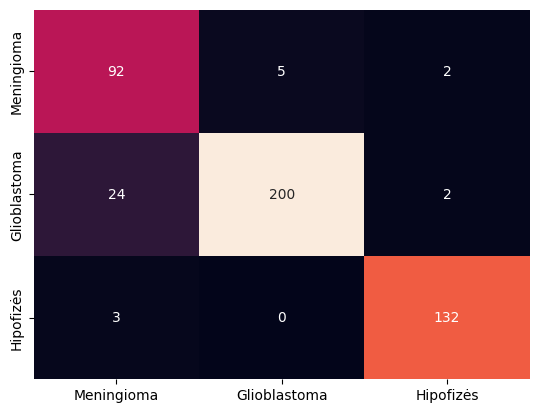

In [ ]:
# spausdinama sumaišties matrica
create_and_print_matrix(ground_truth, predictions)

In [ ]:
# Sukuria painiavos matricą
cm = confusion_matrix(ground_truth, predictions)

# Apskaičiuojame tikslumą kiekvienai klasei
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Spausdiname rezultatus
for i, accuracy in enumerate(accuracy_per_class):
    print(f"Accuracy for class {index_to_label[i+1]}: {accuracy:.2f}")

Accuracy for class meningioma: 0.93
Accuracy for class glioma: 0.88
Accuracy for class pituitary tumor: 0.98


# Modelio testavimas - 2

In [ ]:
# gaunami testavimo rezultatai - spėjamos ir tikrosios testavimo duomenų reikšmės
predictions, ground_truth = evaluate(vgg_model, loader_test)

In [ ]:
# skaičiuojamas tikslumas
correct_predictions = np.sum(predictions == ground_truth)
total_predictions = ground_truth.size
accuracy = correct_predictions / total_predictions
print('Tikslumas', accuracy)

Tikslumas 0.9260869565217391


<Figure size 400x400 with 0 Axes>

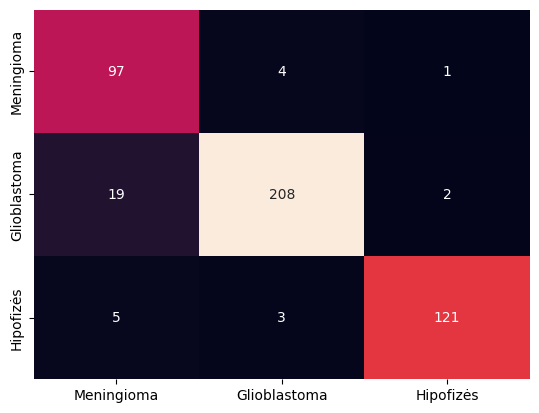

In [ ]:
# spausdinama sumaišties matrica
create_and_print_matrix(ground_truth, predictions)

In [ ]:
# Sukuria painiavos matricą
cm = confusion_matrix(ground_truth, predictions)

# Apskaičiuojame tikslumą kiekvienai klasei
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Spausdiname rezultatus
for i, accuracy in enumerate(accuracy_per_class):
    print(f"Accuracy for class {index_to_label[i+1]}: {accuracy:.2f}")

Accuracy for class meningioma: 0.95
Accuracy for class glioma: 0.91
Accuracy for class pituitary tumor: 0.94


# Modelio testavimas - 3

In [ ]:
# gaunami testavimo rezultatai - spėjamos ir tikrosios testavimo duomenų reikšmės
predictions, ground_truth = evaluate(vgg_model, loader_test)

In [ ]:
# skaičiuojamas tikslumas
correct_predictions = np.sum(predictions == ground_truth)
total_predictions = ground_truth.size
accuracy = correct_predictions / total_predictions
print('Tikslumas', accuracy)

Tikslumas 0.908695652173913


<Figure size 400x400 with 0 Axes>

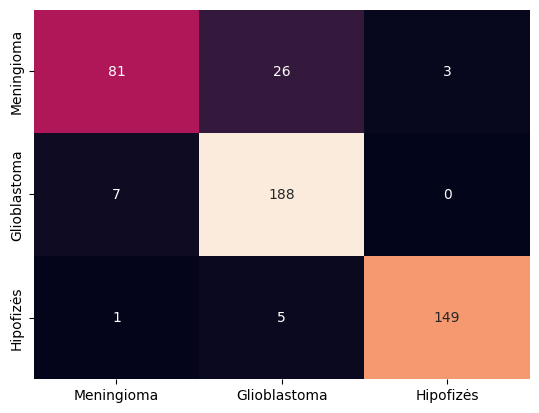

In [ ]:
# spausdinama sumaišties matrica
create_and_print_matrix(ground_truth, predictions)

In [ ]:
# Sukuria painiavos matricą
cm = confusion_matrix(ground_truth, predictions)

# Apskaičiuojame tikslumą kiekvienai klasei
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Spausdiname rezultatus
for i, accuracy in enumerate(accuracy_per_class):
    print(f"Accuracy for class {index_to_label[i+1]}: {accuracy:.2f}")

Accuracy for class meningioma: 0.74
Accuracy for class glioma: 0.96
Accuracy for class pituitary tumor: 0.96


# Modelio testavimas - 4

In [ ]:
# gaunami testavimo rezultatai - spėjamos ir tikrosios testavimo duomenų reikšmės
predictions, ground_truth = evaluate(vgg_model, loader_test)

In [ ]:
# skaičiuojamas tikslumas
correct_predictions = np.sum(predictions == ground_truth)
total_predictions = ground_truth.size
accuracy = correct_predictions / total_predictions
print('Tikslumas', accuracy)

Tikslumas 0.9695652173913043


<Figure size 400x400 with 0 Axes>

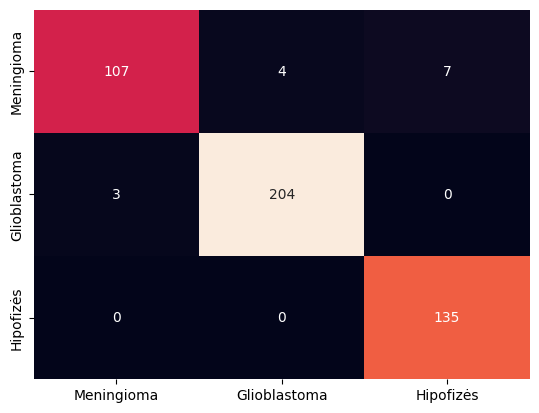

In [ ]:
# spausdinama sumaišties matrica
create_and_print_matrix(ground_truth, predictions)

In [ ]:
# Sukuria painiavos matricą
cm = confusion_matrix(ground_truth, predictions)

# Apskaičiuojame tikslumą kiekvienai klasei
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)

# Spausdiname rezultatus
for i, accuracy in enumerate(accuracy_per_class):
    print(f"Accuracy for class {index_to_label[i+1]}: {accuracy:.2f}")

Accuracy for class meningioma: 0.91
Accuracy for class glioma: 0.99
Accuracy for class pituitary tumor: 1.00


# Modelio išsaugojimas - X

In [ ]:
# prisidedam savo google drive diska
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# išsaugojimas google drive
drive_path = '/content/drive/MyDrive/Colab Notebooks/'
torch.save(vgg_model.state_dict(), drive_path + 'VGG16_X.pth')

In [ ]:
# modelio gavimas iš google drive
model_path = '/content/drive/MyDrive/Colab Notebooks/' + 'VGG16_X.pth'
vgg_model.load_state_dict(torch.load(model_path))

# LRP

In [ ]:
!pip install lrp-pf-auc

In [ ]:
from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt

import lrp.plot
from lrp import image, rules
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear, Activation, Convolution
import torch.nn.functional as F

plt.rcParams['font.size'] = 9

## Pasitestavimas

In [ ]:
idx = 10
image_test = dataset_test[idx][0].unsqueeze(0).to(device)
label_test = dataset_test[idx][1]
mask_test = dataset_test[idx][2]

In [ ]:
relevance1 = lrp_relevance_by_class(vgg_model, image_test, int(label_test), -20, 0)

In [ ]:
print(calculate_lrp_and_mask_iou(relevance1, mask_test))

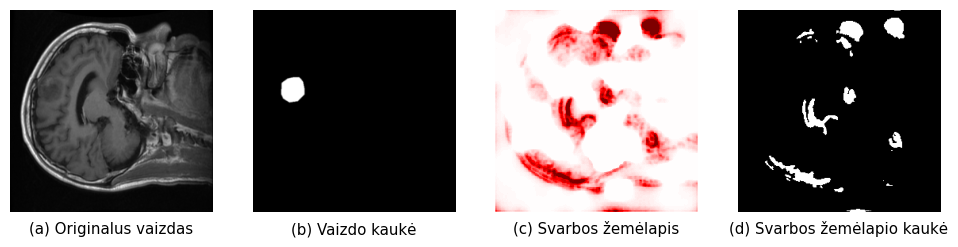

In [ ]:
print_lrp_mask(image_test, mask_test, relevance1, quantile = 0.95)

In [ ]:
relevance1 = lrp_relevance_by_class(vgg_model, image_test, 0, -20, 0)
relevance2 = lrp_relevance_by_class(vgg_model, image_test, 1, -20, 0)
relevance3 = lrp_relevance_by_class(vgg_model, image_test, 2, -20, 0)

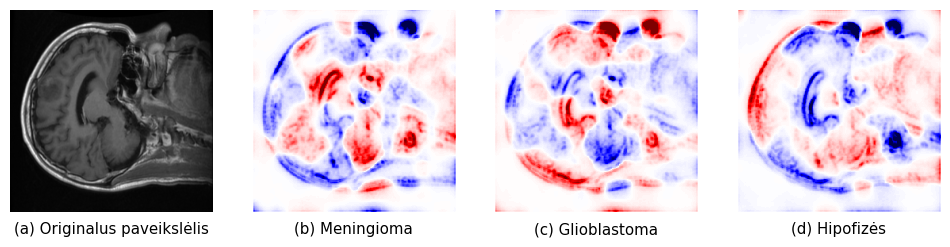

In [ ]:
print_lrp(image_test, relevance1, relevance2, relevance3)

## Funkcijos

In [ ]:
# funkcija, kuri atspausdina tikraji vaizda, jo kauke, gauta svarbos žemėlapį ir sudaryta svarbos kaukę
def print_lrp_mask(image_test, mask_test, relevance1, quantile):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image_test.cpu().detach().squeeze(0).numpy().transpose(1, 2, 0), cmap='gray')
    plt.title('(a) Originalus vaizdas', y=-0.15)
    plt.axis(False)

    plt.subplot(1, 4, 2)
    plt.imshow(mask_test.squeeze(0), cmap='gray')
    plt.title('(b) Vaizdo kaukė', y=-0.15)
    plt.axis(False)

    plt.subplot(1, 4, 3)
    relevance = np.array(relevance1).sum(axis=1)
    b = 10*((np.abs(relevance)).mean())
    plt.imshow(relevance.squeeze(0), cmap=plt.cm.seismic, vmin=-b, vmax=b, interpolation='nearest')
    plt.title('(c) Svarbos žemėlapis', y=-0.15)
    plt.axis(False)

    plt.subplot(1, 4, 4)
    relevance[relevance < 0] = 0
    threshold_relevance = torch.quantile(torch.from_numpy(relevance), quantile)
    binary_relevance_map = (torch.from_numpy(relevance) > threshold_relevance).int()
    plt.imshow(binary_relevance_map.squeeze(0), cmap='gray')
    plt.title('(d) Svarbos žemėlapio kaukė', y=-0.15)
    plt.axis(False)

    plt.show()

In [ ]:
# funkcija, kuri atspausdina svarbos žemėlapius pagal skirtingas klases vienam vaizdui
def print_lrp(X, relevance1, relevance2, relevance3):
  img = X[0].cpu().detach().numpy().transpose(1, 2, 0)
  img /= np.max(img)

  relevance1 = np.array(relevance1).sum(axis=1)
  b1 = 10*((np.abs(relevance1)).mean())

  relevance2 = np.array(relevance2).sum(axis=1)
  b2 = 10*((np.abs(relevance2)).mean())

  relevance3 = np.array(relevance3).sum(axis=1)
  b3 = 10*((np.abs(relevance3)).mean())

  fig, ax = plt.subplots(1, 4, figsize=(12, 4))

  ax[0].imshow(img)
  ax[0].set_title('(a) Originalus paveikslėlis', y=-0.15)
  ax[0].axis('off')

  ax[1].imshow(relevance1.squeeze(0),cmap=plt.cm.seismic,vmin=-b1,vmax=b1,interpolation='nearest')
  ax[1].set_title('(b) Meningioma', y=-0.15)
  ax[1].axis('off')

  ax[2].imshow(relevance2.squeeze(0),cmap=plt.cm.seismic,vmin=-b2,vmax=b2,interpolation='nearest')
  ax[2].set_title('(c) Glioblastoma', y=-0.15)
  ax[2].axis('off')

  ax[3].imshow(relevance3.squeeze(0),cmap=plt.cm.seismic,vmin=-b3,vmax=b3,interpolation='nearest')
  ax[3].set_title('(d) Hipofizės', y=-0.15)
  ax[3].axis('off')

  plt.show()


In [ ]:
# funkcija skaičiuojanti svarbos žemėlapio tikslumą ir kitas metrikas
def calculate_lrp_confusion_metrics(relevance_map, mask):

    relevance_map[relevance_map < 0] = 0
    threshold_relevance = torch.quantile(relevance_map, 0.95)
    binary_relevance_map = (relevance_map > threshold_relevance).int()

    threshold_mask = 0.5
    binary_mask = (mask > threshold_mask).int()

    true_positives = torch.sum(binary_relevance_map * binary_mask)
    false_positives = torch.sum(binary_relevance_map * (1 - binary_mask))
    true_negatives = torch.sum((1 - binary_relevance_map) * (1 - binary_mask))
    false_negatives = torch.sum((1 - binary_relevance_map) * binary_mask)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1_score': f1_score
    }

In [ ]:
# funkcija skaičiuojanti kaukių iou
def calculate_lrp_and_mask_iou(relevance_map, mask):

  relevance_map[relevance_map < 0] = 0
  threshold_relevance = torch.quantile(relevance_map, 0.95)
  binary_relevance_map = (relevance_map > threshold_relevance).int()

  threshold_mask = 0.5
  binary_mask = (mask > threshold_mask).int()

  intersection = torch.sum(binary_mask & binary_relevance_map).item()
  union = torch.sum(binary_mask | binary_relevance_map).item()

  iou = intersection / union if union != 0 else 0

  return iou

In [ ]:
# funkcija sukurianti LRP modeli
def create_lrp_instance(model, gamma, epsilion):
  name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]

  shape: Tuple[int] = (1, 3, 256, 256)

  low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
  high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

  target_types: Tuple[type] = (Linear, AvgPool)
  filter_by_layer_index_type: LayerFilter = LayerFilter(model=model, target_types=target_types)

  name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 17), LrpGammaRule, {'gamma': gamma}),
    (filter_by_layer_index_type(lambda n: 18 <= n <= 30), LrpEpsilonRule, {'epsilon': epsilion}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
  ]

  lrp_instance: LRP = LRP(model)
  lrp_instance.convert_layers(name_map)

  return lrp_instance

In [ ]:
# funkcija kuri įvertina lrp modelį per testinį duomenų rinkinį
def evaluate_lrp_by_image(LRP, model, loader):

  all_metrics_df = pd.DataFrame(columns=['image', 'label', 'model_pred_label', 'model_pred_0', 'model_pred_1', 'model_pred_2', 'iou'])

  for data in loader:
    images = data[0]
    labels = data[1]
    masks = data[2]

    for i in range(len(labels)):
        image = images[i].unsqueeze(0)
        label = int(labels[i].item())
        mask = masks[i]

        with SuppressOutput():
          relevance_map = LRP.relevance(image.to(device), label_idx_n =  torch.tensor([label]))
          relevance = np.array(relevance_map.cpu().detach()).sum(axis=1)
          iou = calculate_lrp_and_mask_iou(torch.from_numpy(relevance), mask)

          pred = model(image.to(device))
          pred_cpu = pred.cpu().detach()
          pred_cpu = F.softmax(pred_cpu, dim=1)
          model_pred_label = int(np.argmax(pred_cpu))
          model_pred_0 = np.array(pred_cpu)[0][0]
          model_pred_1 = np.array(pred_cpu)[0][1]
          model_pred_2 = np.array(pred_cpu)[0][2]

          temp_df = pd.DataFrame({
            'image': [i],
            'label':[label],
            'model_pred_label':[model_pred_label],
            'model_pred_0': [model_pred_0],
            'model_pred_1': [model_pred_1],
            'model_pred_2': [model_pred_2],
            'iou': [iou]
          })

        all_metrics_df = pd.concat([all_metrics_df, temp_df], ignore_index=True)

  output_file_path = 'failo_pavadinimas.xlsx'
  all_metrics_df.to_excel(output_file_path, index=False)

In [ ]:
# funkcija kuri įvertina lrp modelį per testinį duomenų rinkinį
def evaluate_lrp(LRP, loader):
  iou_acc = []
  sum_metrics = {'precision': 0, 'recall': 0, 'accuracy': 0, 'f1_score': 0}

  for data in loader:
    images = data[0]
    labels = data[1]
    masks = data[2]

    for i in range(len(labels)):
        image = images[i].unsqueeze(0)
        label = int(labels[i].item())
        mask = masks[i]

        with SuppressOutput():
          relevance_map = LRP.relevance(image.to(device), label_idx_n =  torch.tensor([label]))
          relevance = np.array(relevance_map.cpu().detach()).sum(axis=1)
          iou = calculate_lrp_and_mask_iou(torch.from_numpy(relevance), mask)
          metrics = calculate_lrp_confusion_metrics(torch.from_numpy(relevance), mask)

          sum_metrics['precision'] += metrics['precision']
          sum_metrics['recall'] += metrics['recall']
          sum_metrics['accuracy'] += metrics['accuracy']
          sum_metrics['f1_score'] += metrics['f1_score']

          iou_acc.append(iou)

  average_metrics = {key: value / 460 for key, value in sum_metrics.items()}
  average_iou = np.mean(iou_acc)

  return average_metrics, average_iou

In [ ]:
# funkcija, kuri suka cikla ir renka rezultatus iš kievienos iteracijos
# rezultatus surašo i excel faila
def evaluete_lrp_and_write_results_to_excel(model, loader):
  start_time = datetime.now()
  all_metrics_df = pd.DataFrame(columns=['iteration', 'gamma', 'epsilion', 'precision', 'recall', 'accuracy', 'f1_score', 'iou'])
  iteration = 0

  for gamma in np.arange(-100, 120, 20):
    for epsilion in np.arange(-100, 120, 20):

      iteration += 1

      lrp_instance = create_lrp_instance(model, gamma, epsilion)
      average_metrics, average_iou = evaluate_lrp(lrp_instance, loader)

      temp_df = pd.DataFrame({
          'iteration': [iteration],
          'gamma':[gamma],
          'epsilion':[epsilion],
          'precision': [average_metrics['precision'].item()],
          'recall': [average_metrics['recall'].item()],
          'accuracy': [average_metrics['accuracy'].item()],
          'f1_score': [average_metrics['f1_score'].item()],
          'iou': [average_iou]
      })

      all_metrics_df = pd.concat([all_metrics_df, temp_df], ignore_index=True)

      current_time = datetime.now()
      elapsed = seconds_to_time((current_time - start_time).total_seconds())
      print(f'Iteration: {iteration}, Time: {elapsed}')

  output_file_path = 'failo_pavadinimas.xlsx'
  all_metrics_df.to_excel(output_file_path, index=False)

In [ ]:
# funkcija, skaičiuojanti svarbos žemėlapį pagal nurodytą klasę
def lrp_relevance_by_class(model, X, idx, gamma, epsilon):
    name_map: List[Tuple[List[str], rules.LrpRule,
                        Dict[str, Union[torch.Tensor, float]]]]

    shape: Tuple[int] = (1, 3, 256, 256)

    low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
    high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

    target_types: Tuple[type] = (Linear, AvgPool, Convolution)
    filter_by_layer_index_type: LayerFilter = LayerFilter(model=model, target_types=target_types)

    name_map = [
        (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
        (filter_by_layer_index_type(lambda n: 1 <= n <= 17), LrpGammaRule, {'gamma': gamma}),
        (filter_by_layer_index_type(lambda n: 18 <= n <= 30), LrpEpsilonRule, {'epsilon': epsilon}),
        (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
    ]

    lrp_instance: LRP = LRP(model)
    lrp_instance.convert_layers(name_map)

    R: torch.Tensor = lrp_instance.relevance(X, label_idx_n = torch.tensor([idx]))

    return R.cpu().detach()

## Paleidimas

In [ ]:
evaluete_lrp_and_write_results_to_excel(vgg_model, loader_test)

In [ ]:
lrp_instance = create_lrp_instance(vgg_model, -20, 0)
evaluate_lrp_by_image(lrp_instance, vgg_model, loader_test)

# Gal kada prireiks...

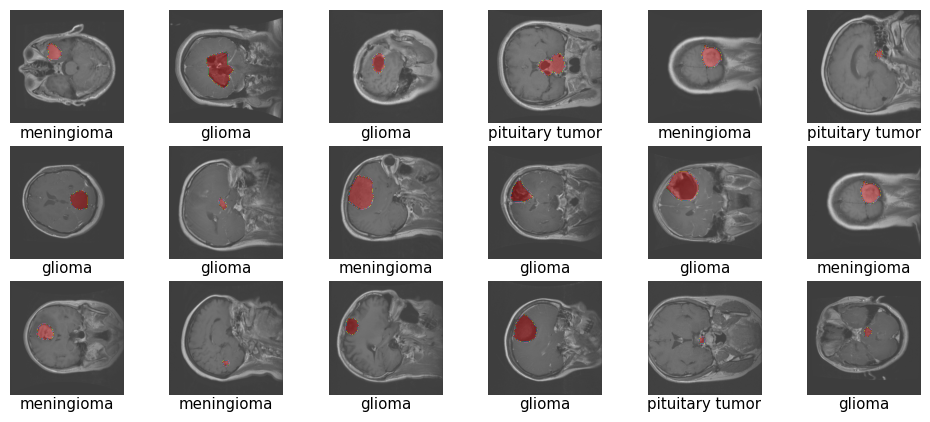

In [ ]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(460, size=18), start=1):
    plt.subplot(3, 6, i)

    image_test = dataset_test[idx][0]
    label_test = dataset_test[idx][1]
    mask_test = dataset_test[idx][2]

    plt.imshow(image_test.numpy().transpose(1, 2, 0), cmap='gray')
    plt.imshow(np.ones_like(mask_test.numpy().squeeze(0))-mask_test.numpy().squeeze(0), alpha=0.4, cmap='Set1')
    plt.title(index_to_label[label_test+1], y=-0.2)
    plt.axis('off')

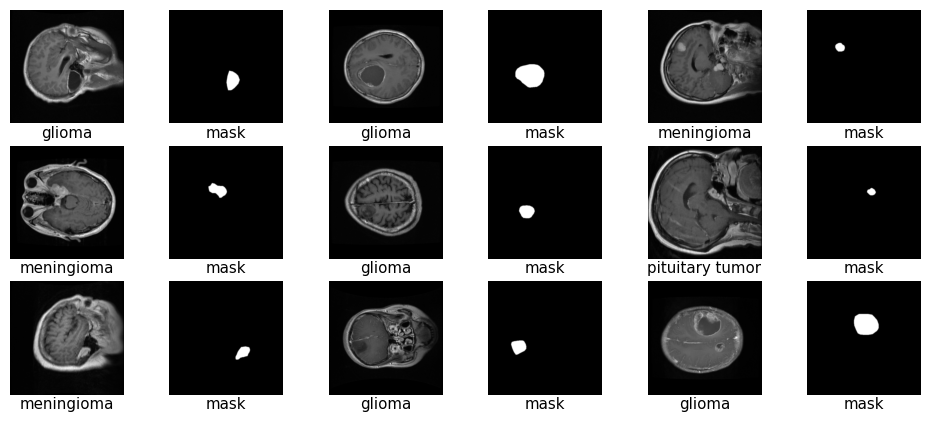

In [ ]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint(460, size=9):
    plt.subplot(3,6,i)
    i+=1

    image_test = dataset_test[idx][0]
    label_test = dataset_test[idx][1]
    mask_test = dataset_test[idx][2]

    plt.imshow(image_test.numpy().transpose(1, 2, 0))
    plt.title(index_to_label[label_test+1], y=-0.2)
    plt.axis('off')

    plt.subplot(3,6,i)
    i+=1

    plt.imshow(mask_test.numpy().squeeze(0), cmap='gray')
    plt.title("mask", y=-0.2)
    plt.axis('off')

In [ ]:
lrp_instance.model